# The center of the Sun in a partial eclipse image

The typical images of a partial solar eclipse are a bright orange disk (the Sun) covered partially by a black disk (the Moon). The two disks are about the same size. The result is an orange area enclosed by two arcs. 

To find the center of the sun, we first find the edge of the image using Canny edge finder. Then we randomly select 3 points from the edge pixels; as long as they do not fall in a straight line, they define a unique circle. We can find the center of the circle. This process is repeated and the statistics of the centers is collected. The coordinates of the real center of a large circle will most likely to be at the highest density point. 

In the case of eclipse, there should be two likely centers, one for the Sun and the other for the Moon. The difference is that for the Sun the center should be on the bright side of the arc; for the Moon it should be on the dark side. So 
we can check if the vector from a point on the arc is in a similar direction of the gradient at that point. If not, the result is rejected.



### The center of the circle defined by 3 points
Given three points on a circle, we can determine the center. Let $(x_i, y_i)$ be the $i$-th point on a circle, and the center of the circle be $(x_0, y_0)$. They satisfy the equations

$$
(x_i-x_0)^2 + (y_i-y_0)^2 = r^2.
$$

Subtracting the equation with $i=2$ from that with $i=1$, we have

$$
x_1^2 - x_2^2 + y_1^2 - y_2^2 - 2x_0(x_1-x_2) - 2y_0(y_1-y_2) = 0.
$$

Let $m_{ij} = (y_i-y_j)/(x_i-x_j)$, $\bar{x}_{ij} = (x_i+x_j)/2$, $\bar{y}_{ij} = (y_i+y_j)/2$, and use the fact $a^2-b^2 = (a+b)(a-b)$, and the above equation becomes

$$
x_0 + m_{ij} y_0 = \bar{x}_{ij} + m_{ij}\bar{y}_{ij}.
$$

Now we can solve $(x_0, y_0)$ using the equations

\begin{align}
x_0 + m_{12} y_0 &= \bar{x}_{12} + m_{12}\bar{y}_{12}, \\
x_0 + m_{13} y_0 &= \bar{x}_{13} + m_{13}\bar{y}_{13}
\end{align}

We arrive at

\begin{align}
x_0 &= \frac{m_{13}\bar{x}_{12} - m_{12}\bar{x}_{13} + m_{12}m_{13}(\bar{y}_{12}-\bar{y}_{13})} {m_{13}-m_{12}}\\
y_0 &= -\frac{\bar{x}_{12} - \bar{x}_{13} + m_{12}\bar{y}_{12}-m_{13}\bar{y}_{13}} {m_{13}-m_{12}}\\
\end{align}

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import io as skio

## Load the test image

The image is in a tiff format, converted by dcraw from the raw file of Sony A6000. The data format is 16-bit integer.

In [3]:
img = skio.imread('testimg.tiff')/(2**16-1)
print(img.dtype)

float64


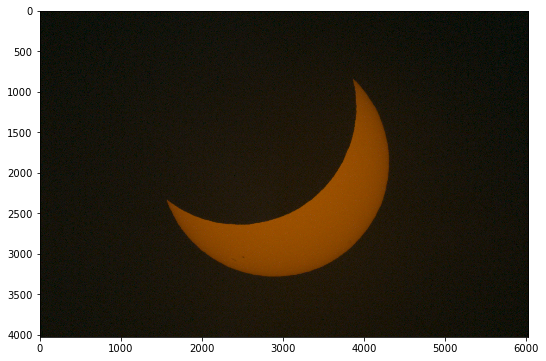

In [4]:
plt.figure(figsize=(9,6))
plt.imshow(img**0.45);

## Find the edge

Use Canny filter to find the edge; use sigma=3 to reduce noise. 

In [5]:
# Use the R channel only. Scale so that the maximum is 1.
imgR = img[...,0]/img[...,0].max()
edges3 = feature.canny(imgR, sigma=3)
print((edges3==True).sum())
print(edges3.shape)

10041
(4024, 6024)


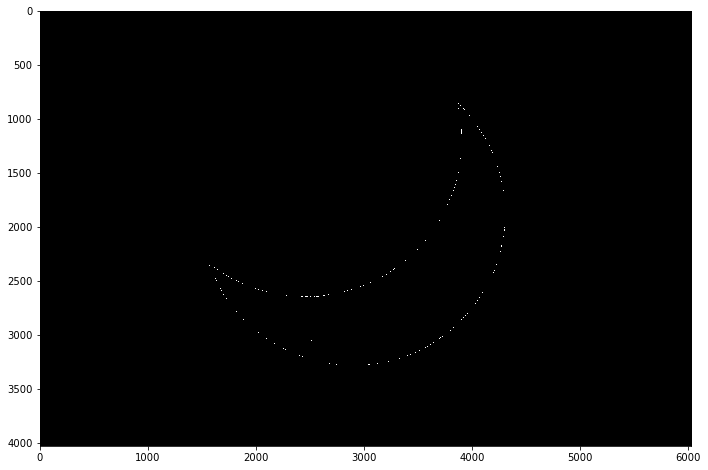

In [6]:
plt.figure(figsize=(12,8))
plt.imshow(edges3, cmap='gray');

## Find the gradient

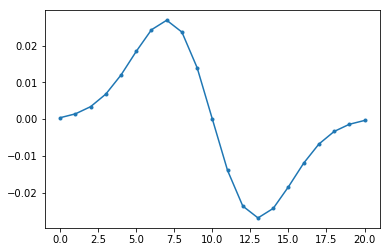

In [7]:
# The kernel: first derivative of a Gaussian
delta = np.zeros(21, dtype=float)
delta[int(len(delta)/2)] = 1.0
kgaus = ndi.filters.gaussian_filter1d(delta, sigma=3, order=1)
plt.plot(kgaus, '.-');
kgaus = kgaus.reshape((len(kgaus), 1))

In [8]:
# x direction
grad_x = ndi.convolve(imgR.transpose(), kgaus).transpose()
grad_y = ndi.convolve(imgR, kgaus)

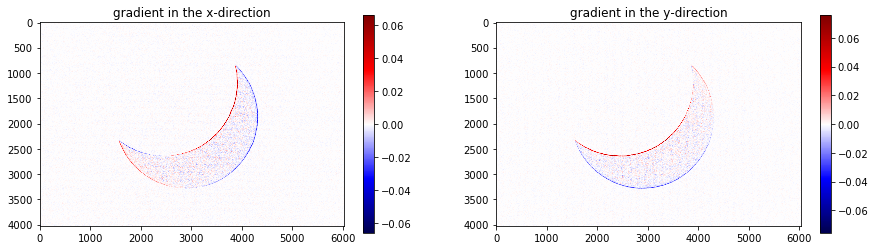

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(grad_x, cmap='seismic', vmin=-np.abs(grad_x).max(), vmax=np.abs(grad_x).max())
plt.title('gradient in the x-direction', fontsize='large')
plt.colorbar(shrink=0.8);
plt.subplot(122)
plt.imshow(grad_y, cmap='seismic', vmin=-np.abs(grad_y).max(), vmax=np.abs(grad_y).max())
plt.title('gradient in the y-direction', fontsize='large')
plt.colorbar(shrink=0.8);

## Find center statistics

In [10]:
def cxy3pt(xcoords, ycoords):
    '''
    Return the center coordinate as a 2-tuple in xy style. If the three points are in a line,
    return None.
    Parameters:
    -----------
    xcoords: 1d array-like of length 3
    ycoords: 1d array-like of length 3
    '''
    x1, x2, x3 = xcoords
    y1, y2, y3 = ycoords
    v12 = np.array([x1-x2, y1-y2])
    v13 = np.array([x1-x3, y1-y3])
    # Are the vectors too small? (in terms of pixels)
    if np.sum(v12**2) < 2 or np.sum(v13**2) < 4:
        return None, None
    # Do they form a small angle?
    if np.abs(np.cross(v12, v13))/np.sqrt(np.sum(v12**2)*np.sum(v13**2)) < 0.1:
        return None, None

    if x1 == x2:
        # swap 1, 3
        x1, x3 = x3, x1
        y1, y3 = y3, y1
    elif x1 == x3:
        # swap 1, 2
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    x12 = (x1+x2)/2
    x13 = (x1+x3)/2
    y12 = (y1+y2)/2
    y13 = (y1+y3)/2
    m12 = (y1-y2)/(x1-x2)
    m13 = (y1-y3)/(x1-x3)

    x0 = (m13*x12 - m12*x13 + m12*m13*(y12-y13)) / (m13-m12)
    y0 = -(x12 - x13 + m12*y12 - m13*y13) / (m13-m12)
    
    return x0, y0

def accept_by_gradient(cxy, pij, grad_x, grad_y):
    '''
    Accept this center or not, based on the vector direction of center-point and the gradient direction.
    Return a bool.
    Parameters:
    ------------
    cxy: a 2-tuple, the (x,y) coordinates of the test center.
    pij: a list of 2-tuples, or array of shape (n, 2) for the i,j indices of the n points on the arc
    grad_x, grad_y: array like. Maps of gradients in x and in y directions.
    '''
    ret = True
    for pp in pij:
        gx = grad_x[tuple(pp)]
        gy = grad_y[tuple(pp)]
        # vector from the point to the test center
        vr = (cxy[0]-pp[1], cxy[1]-pp[0])
        # if their inner product is negative, reject
        if vr[0]*gx + vr[1]*gy < 0:
            ret = False
            break
    return ret

\begin{align}
x_0 &= \frac{m_{13}\bar{x}_{12} - m_{12}\bar{x}_{13} + m_{12}m_{13}(\bar{y}_{12}-\bar{y}_{13})} {m_{13}-m_{12}}\\
y_0 &= -\frac{\bar{x}_{12} - \bar{x}_{13} + m_{12}\bar{y}_{12}-m_{13}\bar{y}_{13}} {m_{13}-m_{12}}\\
\end{align}

In [11]:
# edges coordinates
eycoords, excoords = np.where(edges3)
print(len(excoords), len(eycoords))

10041 10041


In [12]:
# permutate the order
np.random.seed(8234)
idx = np.random.permutation(len(excoords))
excoords = excoords[idx]
eycoords = eycoords[idx]

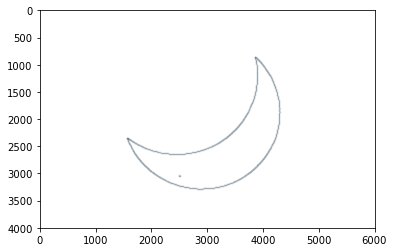

In [13]:
plt.scatter(excoords, eycoords, alpha=0.01, s=0.5);
plt.xlim(0, 6000);
plt.ylim(4000, 0);

In [14]:
ppp = np.vstack((excoords[5:8], eycoords[5:8])).transpose()
print(ppp)

[[2331 2635]
 [4288 1699]
 [3867  902]]


In [15]:
centers = []
accepts = []
for i in range(0, len(idx)-3, 3):
    x0, y0 = cxy3pt(excoords[i:i+3], eycoords[i:i+3])
    if x0 is not None and y0 is not None:
        centers.append((x0, y0))
        pointsij = np.vstack((eycoords[i:i+3], excoords[i:i+3])).transpose()
        accepts.append(accept_by_gradient((x0,y0), pointsij, grad_x, grad_y))

centers = np.array(centers)

In [16]:
np.shape(accepts)

(2973,)

In [17]:
print(centers.shape)
xm, ym = centers.mean(axis=0)
print(xm, ym)

(2973, 2)
2995.57202229 2053.83426975


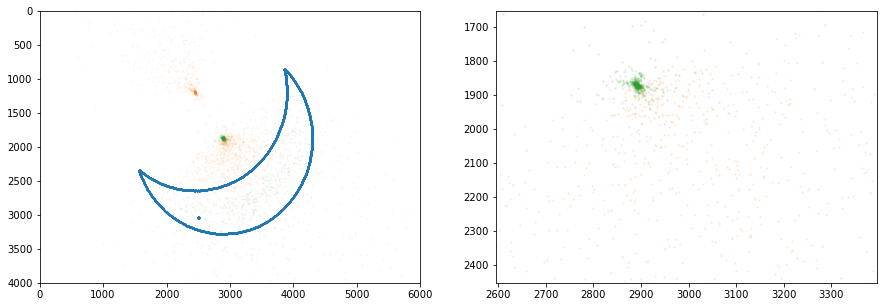

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(excoords, eycoords, marker='.', s=1)
plt.scatter(centers[np.asarray(accepts)==False,0], centers[np.asarray(accepts)==False,1], alpha=0.05, s=1)
plt.scatter(centers[accepts,0], centers[accepts,1], alpha=0.05, s=1)
plt.xlim(0, 6000)
plt.ylim(4000,0);
#
plt.subplot(122)
plt.scatter(centers[np.asarray(accepts)==False,0], centers[np.asarray(accepts)==False,1], alpha=0.1, s=2, color='C1')
plt.scatter(centers[accepts,0], centers[accepts,1], alpha=0.1, s=2, color='C2')
plt.xlim(xm-400, xm+400);
plt.ylim(ym+400, ym-400);

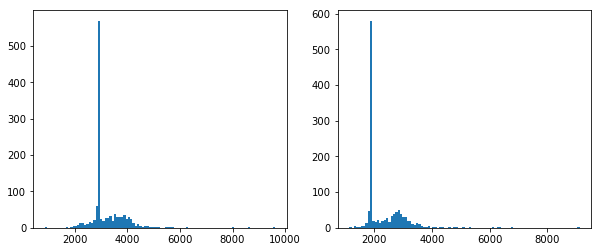

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(centers[accepts, 0], bins=100);
plt.subplot(122)
plt.hist(centers[accepts, 1], bins=100);